# NB to develop the functions that would transform in general any bunch of files, with any table name, energy name, coord names, etc... Into the input for NEXT_SPARSECONVNET

There are 2 steps. 
* One is the column names transformation / adaptation. 
* The other is that the SCN takes 3 files (train-valid-test), so we should "MIX" all of the events, creating an identificator where this ID leads to file, data type and number of event of the original ones...

Maybe the best way is to just transform the files as they are, and then do the grouping thing... Well no, because that should be DOUBLE file transformation... we should do it all at once I think

Mirar como guidance el create_whole_voxel_dataset de data_labelling... En el junta voxeles del mismo tipo, puedo ir haciendo algo así pero con un shuffle antes, una división de ficheros (la putada es que para un shuffle completo necesito tener TODO abierto no???), y luego ir guardando todo... PF no sé que follón.

Casi habría que hacer:

* Algo que me divida equally el # de ficheros de cada tipo de datos (es decir, el 80% + 10% + 10% tanto de 0nubb como de 1eroi)
* Una vez tengo eso, los dos 80% de train de cada tipo van juntos a un df, los dos 10% de valid de cada tipo van juntos a otro.. etc
* Guardo tal y como lee la red

Luego la red ya hace el shuffle ella misma de eventos....... No me gusta nada este aproach, pero es lo que hay creo, si no quiero cambiar todo muchisimo... AGOTADOR

ENTONCES 

* 1: función que me cree una lista de ficheros para meter en train, valid y data; solo los divide por cantidad, haciendo un reparto justo entre los 3 datasets y según el datatype, NO shufflea, no tendría sentido shufflear ficheros, y que luego vaya un pegote de eventos del mismo fichero, así va pegote de cada tipo y se shufflea al entrenar.
* 2: función que para cada lista de ficheros me cree un fichero (es decir, pille el df, lo transforme, y lo guarde tal y como se requiere)

In [1]:
import glob
import pandas as pd
import numpy as np
import tables as tb
import os

import matplotlib.pyplot as plt
import invisible_cities.io.dst_io as dio

In [ ]:
p = '13bar'
basedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{p}/'.format(p=p)

dt = ['0nubb', '1eroi']
prod_type = 'sensim_15mm_vox'
proddir = '{dt}' + '/prod/{prodt}/*'.format(prodt = prod_type)

datasets = ['train', 'valid', 'test']

savedir = basedir + 'dataset_{p}_{prodt}_scn_'.format(p=p, prodt = prod_type) + '{dataset}.h5'


In [2]:
# FOR LABELLED DATA IN HE_CALIB

p = '4bar'
basedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/{p}/'.format(p=p)

dt = ['208Tl']
label_type = 'label' #'interp_label' # 'label'
prod_type = 'PORT_1a/{lt}/prod'.format(lt = label_type)
proddir = '{dt}' + '/prod/{prodt}/*'.format(prodt = prod_type)

datasets = ['train', 'valid', 'test']

savedir = basedir + 'dataset_{p}_{prodt}_scn_'.format(p=p, prodt = 'PORT_1a_{lt}'.format(lt = label_type)) + '{dataset}.h5'

In [4]:
def get_and_split_files(files, train_perc = 0.8, valid_perc = 0.1):
    train_num = int(len(files) * train_perc)
    valid_num = int(len(files) * valid_perc)
    train_files = files[:train_num]
    valid_files = files[train_num:train_num + valid_num]
    test_files  = files[train_num + valid_num:]
    return train_files, valid_files, test_files

In [5]:
def get_dataset_files(directory, dt, perc = 1, train_perc = 0.8, valid_perc = 0.1):
    train, valid, test = [], [], []
    for d in dt:
        files_dir = glob.glob(directory.format(dt = d))
        files = sorted(files_dir, key = lambda x: int(x.split('_')[-2]))
        fil_num = int(len(files) * perc)
        train_files, valid_files, test_files = get_and_split_files(files[:fil_num], train_perc=train_perc, valid_perc=valid_perc)
        train.extend(train_files)
        valid.extend(valid_files)
        test.extend(test_files)
    return train, valid, test

In [5]:
table_group = 'Sensim'
table_name  = 'sns_vox_df'
event_info_tb_name = 'voxel_info'

file_percentage = 0.5
id_name = 'event'
coords_name = ['xbin', 'ybin', 'zbin']
ener_name = 'ebin'
label_name = ['segclass', 'decolabel', 'extlabel']
norm_ener = True
seg_dct = {1:0, 2:1, 3:2}


In [6]:
table_group = 'DATASET' # 'Sensim'
table_name  = 'RecoVoxels' # 'sns_vox_df'
event_info_tb_name = 'BinsInfo' # 'voxel_info'

file_percentage = 1
id_name = 'dataset_id' #'event'
coords_name = ['xbin', 'ybin', 'zbin']
ener_name = 'energy' #'ebin'
label_name = ['segclass', 'decolabel', 'extlabel']
norm_ener = True
seg_dct = None


In [7]:

for dataset, infiles in zip(datasets, get_dataset_files(basedir + proddir, dt, file_percentage)):
    print('Creating ', dataset, ' dataset with ', len(infiles), ' files')
    savefile = savedir.format(dataset = dataset)
    print('Saving it into: ', savefile)
    start_id = 0
    index_count = 0
    for nfil, file in enumerate(infiles):
        if nfil % 50 == 0:
            print(nfil)
        pathname, basename = os.path.split(file)
        df = pd.read_hdf(file, table_group + '/' + table_name)

        # This is needed for Sensim because labels are set from 1 to 3 (ghost class never appears, as spurious hits always come from a certain MC hit)
        # This reminds me, now I could "update" the labelling method for Sensim, given that now is quite simple (fewer functions are used)
        # For label, no need because the ghost_class is 0
        if seg_dct and 'segclass' in label_name:
            df = df.assign(segclass = df['segclass'].map(seg_dct))

        # If the file has EventsInfo (they come from labelling), we use directly that table
        # If the file does not have that table (coming from Sensim), we create it and do a mapping
        with tb.open_file(file, 'r') as h5in:
            exist_eventinfo = '/DATASET/EventsInfo' in h5in
            
        if not exist_eventinfo:
            eventInfo = df[[id_name, 'binclass']].drop_duplicates().reset_index(drop=True)
            eventInfo = eventInfo.assign(pathname = pathname, basename = basename)
        else:
            eventInfo = pd.read_hdf(file, 'DATASET/EventsInfo')

        dct_map = {eventInfo.iloc[i][id_name] : i+start_id for i in range(len(eventInfo))}
        df = df[[id_name]+ ['binclass'] + coords_name + [ener_name] + label_name]
        df = df.assign(dataset_id = df[id_name].map(dct_map))
    
        eventInfo = eventInfo.assign(dataset_id = eventInfo[id_name].map(dct_map))
        eventInfo = eventInfo.merge(df.groupby(id_name)[ener_name].sum().rename('total_energy'), on = id_name)

        eventInfo = eventInfo.assign(
            stridx = df.groupby(id_name).apply(lambda x: x.index[0]).values + index_count,
            endidx   = df.groupby(id_name).apply(lambda x: x.index[-1]).values + 1 + index_count
        )

        if not exist_eventinfo: df = df.drop(id_name, axis = 1)
        
        # Change column names to have the ones read in the NN code
        df = df.rename(columns = {coords_name[0]:'xbin', 
                                coords_name[1]:'ybin', 
                                coords_name[2]:'zbin', 
                                ener_name:'energy'})

        if norm_ener:
            df['energy'] = df.groupby('dataset_id')['energy'].apply(lambda x: x / x.sum())
        start_id += len(eventInfo)
        index_count += len(df)
        # Write the voxels of each file
        with tb.open_file(savefile, 'a') as h5out:
            dio.df_writer(h5out, df       , 'DATASET', 'Voxels'    , columns_to_index=['dataset_id'], compression = "ZLIB4")
            dio.df_writer(h5out, eventInfo, 'DATASET', 'EventsInfo', columns_to_index=['dataset_id'], str_col_length=128, compression = "ZLIB4")

    print(start_id, ' events saved')

    # Write the other info
    binsInfo = dio.load_dst(file, table_group, event_info_tb_name)
    # Assure it has nbins info
    if 'nbins_x' not in binsInfo:
        for coord in ['x', 'y', 'z']:
            min_, max_, size = binsInfo['min_' + coord].values[0], binsInfo['max_' + coord].values[0], binsInfo['size_' + coord].values[0]
            binsInfo['nbins_' + coord] = len(np.arange(min_, max_ + size, size)) - 1
    with tb.open_file(savefile, 'a') as h5out:
        dio.df_writer(h5out, binsInfo , 'DATASET', 'BinsInfo', compression = "ZLIB4")

Creating  train  dataset with  1200  files
Saving it into:  /mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/4bar/dataset_4bar_PORT_1a_label_scn_train.h5
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
119703  events saved
Creating  valid  dataset with  150  files
Saving it into:  /mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/4bar/dataset_4bar_PORT_1a_label_scn_valid.h5
0
50
100
14990  events saved
Creating  test  dataset with  150  files
Saving it into:  /mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/HE_calib/4bar/dataset_4bar_PORT_1a_label_scn_test.h5
0
50
100
15038  events saved


In [9]:
data = dio.load_dst('/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/graph_sensim_trains/15mm_scn/dataset_5bar_sensim_15mm_vox_scn_test_no_norm.h5', 'DATASET', 'Voxels')

In [37]:
import sys
sys.path.append(os.getenv('HOME') + '/data_labelling/')

from utils.plotting_utils import plot_3d_hits, plot_3d_vox, plot_cloud_voxels_and_hits, plot_cloud_voxels_and_hits_discrete

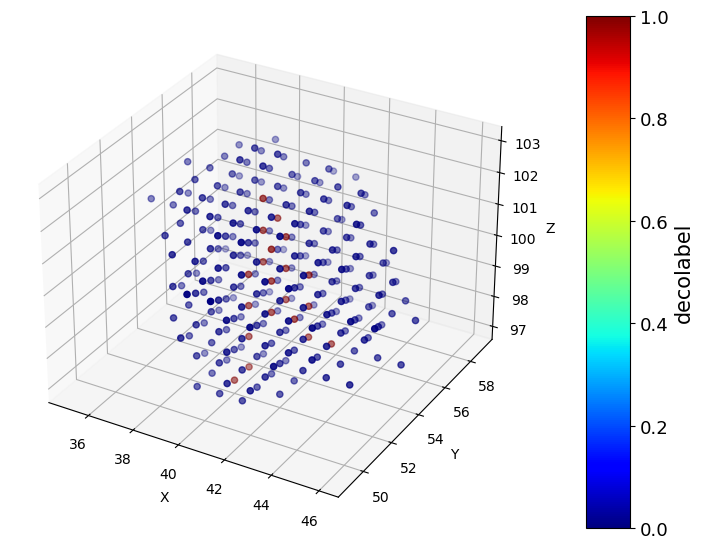

In [47]:
ev = 120
event = data[data.dataset_id == ev]
plot_3d_hits(event, 'decolabel', coords=['xbin', 'ybin', 'zbin'])

In [16]:
data_info = data.groupby(['dataset_id', 'decolabel']).agg({'energy':[('decoener', 'sum'), ('deconvox', 'count')]})

data_info.columns = data_info.columns.get_level_values(1)

data_info.reset_index(inplace = True)

data_info['ratio_ene_vox'] = data_info.decoener.values / data_info.deconvox.values

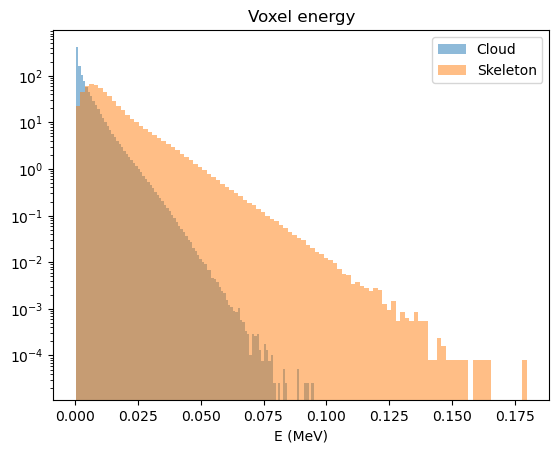

In [11]:
plt.hist(data[data.decolabel == 0].energy, 100, density = True, alpha = 0.5, label = 'Cloud')
plt.hist(data[data.decolabel == 1].energy, 100, density = True, alpha = 0.5, label = 'Skeleton')
plt.title('Voxel energy')
plt.xlabel('E (MeV)')
plt.yscale('log')
plt.legend()
plt.show()

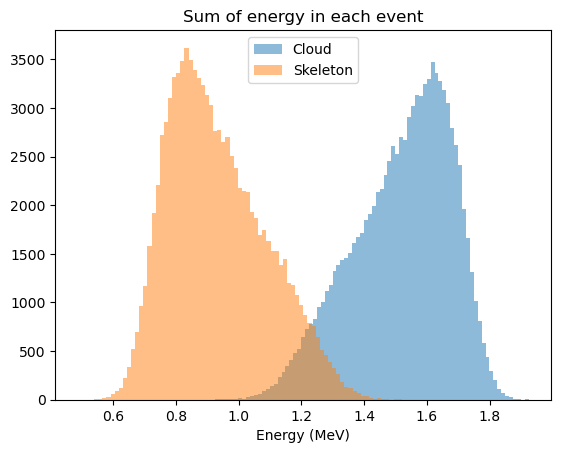

In [18]:
plt.hist(data_info[data_info.decolabel == 0].decoener, 80, alpha = 0.5, label = 'Cloud')
plt.hist(data_info[data_info.decolabel == 1].decoener, 80, alpha = 0.5, label = 'Skeleton')
plt.title('Sum of energy in each event')
plt.xlabel('Energy (MeV)')
plt.legend()
plt.show()

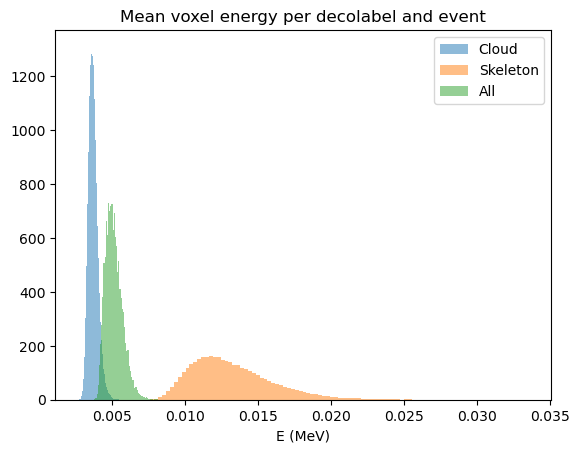

In [24]:
plt.hist(data_info[data_info.decolabel == 0].ratio_ene_vox, 100, density = True, alpha = 0.5, label = 'Cloud')
plt.hist(data_info[data_info.decolabel == 1].ratio_ene_vox, 100, density = True, alpha = 0.5, label = 'Skeleton')
plt.hist(data_info.groupby('dataset_id').sum().decoener / data_info.groupby('dataset_id').sum().deconvox, 90, density=True, alpha = 0.5, label = 'All') 
plt.title('Mean voxel energy per decolabel and event')
plt.xlabel('E (MeV)')
# plt.yscale('log')
plt.legend()
plt.show()